In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_folder = './data/train'

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5774 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

In [ ]:
len(dataset)

181

In [ ]:
181*32

5792

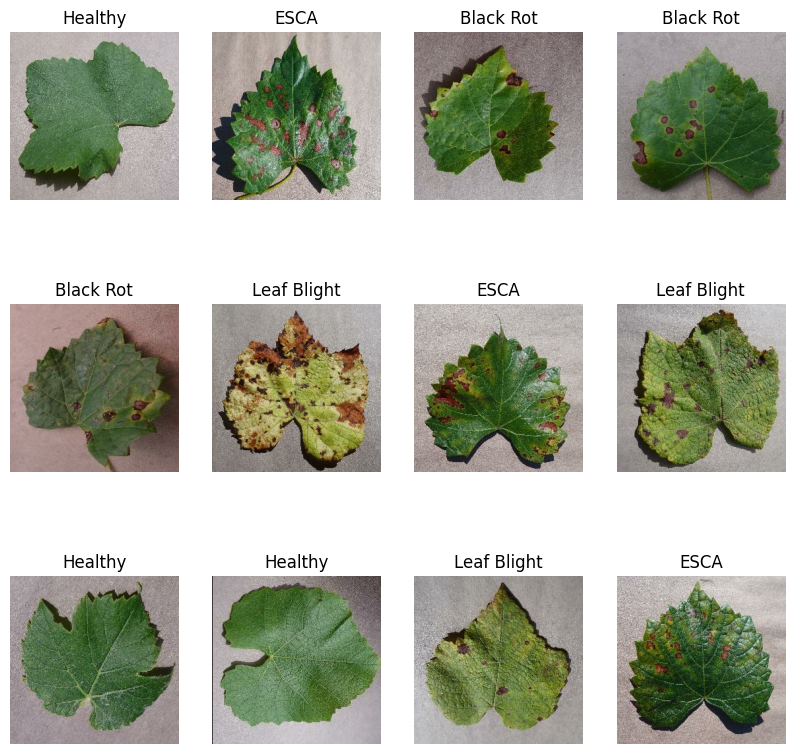

In [ ]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
len(dataset)

181